                                # The Project is Wind Data Analysis

Data Description as it was found in https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset

Context

In Wind Turbines, Scada Systems measure and save data's like wind speed, wind direction, generated power etc. for 10 minutes intervals. This file was taken from a wind turbine's scada system that is working and generating power in Turkey.

Content
The data's in the file are:

    1) Date/Time (for 10 minutes intervals)
    2) LV ActivePower (kW): The power generated by the turbine for that moment
    3) Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
    4) TheoreticalPowerCurve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
    5)Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#Installing windrose to have the wind direction overview
#!pip install windrose
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
from windrose import WindroseAxes

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [41]:
# Importing the data needed for the analysis into panda dataframe

df = pd.read_csv('T1.csv')

In [42]:
#checking the first 5 set of data in the dataframe
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [43]:
#checking if the dataframe contains null
df.isna().sum()

Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [44]:
#Covert Data/time to index and drop columns Date/Time
df.index=df['Date/Time']
df.drop(['Date/Time'], axis=1, inplace=True)

In [45]:
#New DataFrame after dropping column Date/Time
df.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


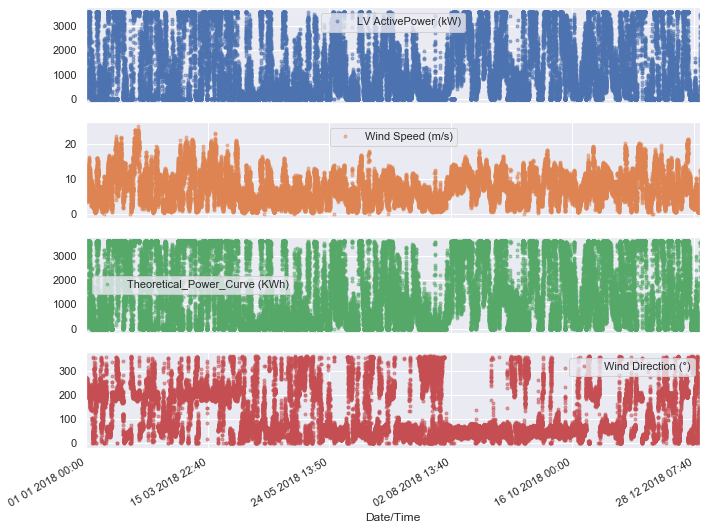

In [46]:
#plotting each data
cols_plot = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)','Wind Direction (°)']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

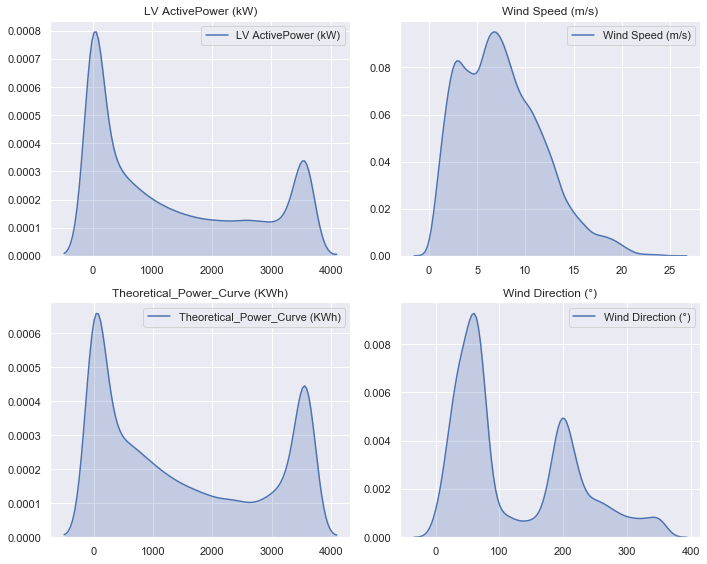

In [47]:
# Plot the data distributions
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(df.iloc[:,i], shade=True)
    plt.title(df.columns[i])
plt.tight_layout()
plt.show()

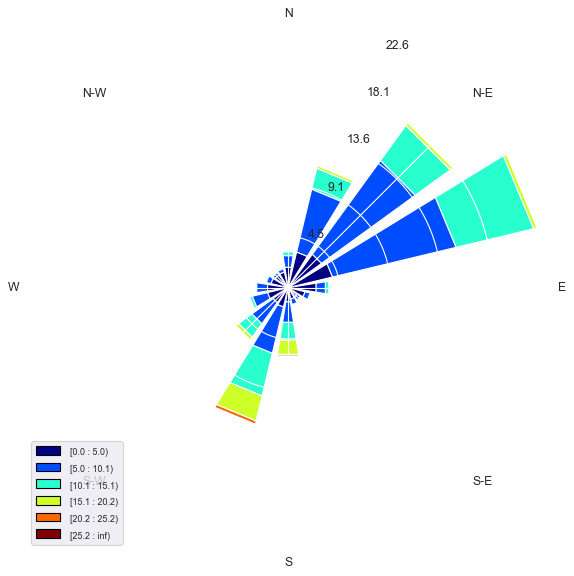

In [48]:
# Create wind speed and direction variables
ax = WindroseAxes.from_ax()
ax.bar(df['Wind Direction (°)'], df['Wind Speed (m/s)'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

The wind rose plot above shows that the wind direction is mostly from the north east while some significant wind also come from the south-west.

In [49]:
#Checking for maximum and minimum value of the wind direction to help in choosing the right binning value
print(df['Wind Direction (°)'].max())
print(df['Wind Direction (°)'].min())

359.99758911132795
0.0


In [50]:
#Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
#Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
#df['Wind Speed (m/s) Bin'] = pd.qcut(df['Wind Speed (m/s)'], 4)

 #Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
#df['Wind Direction (°)'] = pd.cut(df['Wind Direction (°)'].astype(int), 45)

In [51]:
#df

In [52]:
#Bining the data by the wind direction
bins_range = np.arange(0,375,45)

In [53]:
print(bins_range)

[  0  45  90 135 180 225 270 315 360]


In [54]:
#Write a short code to map the bins data
def binning(x, bins):
    kwargs = {}
    if x == max(bins):
        kwargs['right'] = True
    bin = bins[np.digitize([x], bins, **kwargs)[0]]
    bin_lower = bins[np.digitize([x], bins, **kwargs)[0]-1]
    return '[{0}-{1}]'.format(bin_lower, bin)

In [55]:
df['Bin'] = df['Wind Direction (°)'].apply(binning, bins=bins_range)

In [56]:
#group the binned data by mean and std
grouped = df.groupby('Bin')
grouped_std = grouped.std()
grouped_mean = grouped.mean()
grouped_mean.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Bin,,,,
[0-45],1138.411865,7.284140,1425.913297,28.846724
[135-180],1023.474388,6.438602,1105.973131,162.328981
[180-225],2080.714602,10.367445,2238.586793,201.573860
[225-270],711.123621,5.549333,847.241618,246.004417
[270-315],364.405454,4.081395,428.531340,290.525356


The analysis above shows that highest avearge wind speed was recorded around 180(°)-225(°). 

Contrary to the opinion once had from the windrose plot, south - southwest shows good site for wind turbine because it has the highest avearge wind speed. The region also also has highest theoretical power amd LV active power.

In [57]:
#Checking for maximum and minimum value of the windspeed to help in choosing the right binning value
print(df['Wind Speed (m/s)'].max())
print(df['Wind Speed (m/s)'].min())

25.2060108184814
0.0


In [58]:
#Bining the data by the wind direction
bins_range_ws = np.arange(0,26,0.5)

In [59]:
df['Bin'] = df['Wind Speed (m/s)'].apply(binning, bins=bins_range_ws)

In [60]:
#Group by windspeed bin
grouped = df.groupby('Bin')
grouped_std = grouped.std()
grouped_mean = grouped.mean()
grouped_mean

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Bin,,,,
[0.0-0.5],0.000000,0.365804,0.000000,162.505971
[0.5-1.0],0.000000,0.778586,0.000000,170.854432
[1.0-1.5],0.000411,1.260064,0.000000,175.189300
[1.5-2.0],0.010590,1.759065,0.000000,176.404131
[10.0-10.5],2337.270905,10.253631,2937.008035,96.637178
[10.5-11.0],2622.546737,10.748151,3173.479505,95.600305
[11.0-11.5],2858.359373,11.250353,3351.673813,104.367578
[11.5-12.0],3142.711254,11.746023,3474.949240,109.737906
[12.0-12.5],3311.716786,12.235626,3552.269674,114.318559


In [61]:
#lets rearrange the index for proper visualisation
step = bins_range_ws[1]-bins_range_ws[0]
new_index = ['[{0}-{1}]'.format(x, x+step) for x in bins_range_ws]
new_index.pop(-1) #We dont need [360-375]...
grouped_mean = grouped_mean.reindex(new_index)

In [62]:
#Rearranged and visulaizing the mean of each windspeed bin 
grouped_mean

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Bin,,,,
[0.0-0.5],0.000000,0.365804,0.000000,162.505971
[0.5-1.0],0.000000,0.778586,0.000000,170.854432
[1.0-1.5],0.000411,1.260064,0.000000,175.189300
[1.5-2.0],0.010590,1.759065,0.000000,176.404131
[2.0-2.5],0.147161,2.257685,0.000000,165.121134
[2.5-3.0],1.573017,2.748982,0.000000,158.107974
[3.0-3.5],11.050656,3.240103,29.953759,144.551439
[3.5-4.0],52.400688,3.748835,86.474149,139.208026
[4.0-4.5],122.285245,4.251673,171.736466,137.531497


Looking at the table above, it can be assumed that the cut-in wind speed is 3.0-3.5 (m/s), rated wind speed is 12.5-13.0 (m/s) and cut-out wind speed is around 25(m/s). This analysis will be us to determine better filter condition in the power curve analysis.

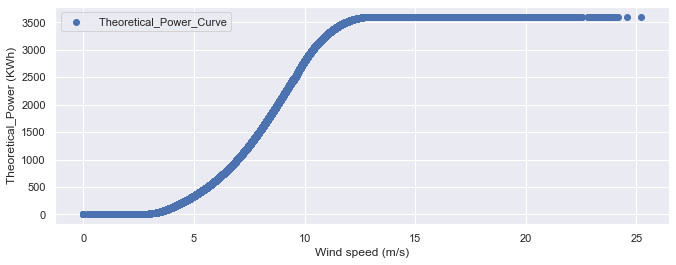

In [63]:
#Power Curve Anaylsis
#Theoretical power curve
plt.scatter(df['Wind Speed (m/s)'],df['Theoretical_Power_Curve (KWh)'])
plt.ylabel('Theoretical_Power (KWh)')
plt.xlabel('Wind speed (m/s)')
plt.grid(True)
plt.legend([' Theoretical_Power_Curve'], loc='upper left')
plt.show()

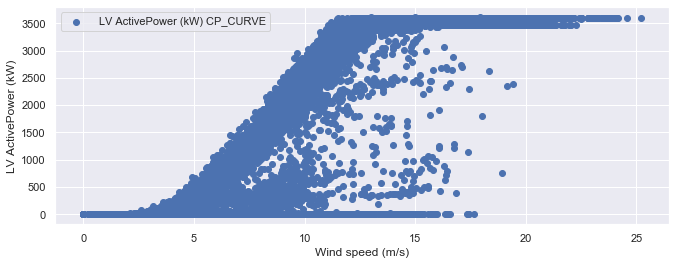

In [64]:
# LV ActivePower (kW) CP_CURVE
plt.scatter(df['Wind Speed (m/s)'],df['LV ActivePower (kW)'])
plt.ylabel('LV ActivePower (kW)')
plt.xlabel('Wind speed (m/s)')
plt.grid(True)
plt.legend([' LV ActivePower (kW) CP_CURVE'], loc='upper left')
plt.show()

Using the information gathered above, we can now set a filter condition for our LV ActivePower (kW) power curve

In [65]:
#Condition 1
#The first step is the removal of downtime events, which can be identified as near-zero power at high wind speeds.

new = (df[(df['Wind Speed (m/s)'] < 4.5) | (df['LV ActivePower (kW)'] > 100.0) ])

In [66]:
#Condition 2
new_1 = (new[ (new['Wind Speed (m/s)'] < 12.5)  | (new['LV ActivePower (kW)'] >= 3000) ])

In [67]:
#Condition 3
new_2 = (new_1[ (new_1['Wind Speed (m/s)'] < 9.5)  | (new_1['LV ActivePower (kW)'] >= 1500) ])

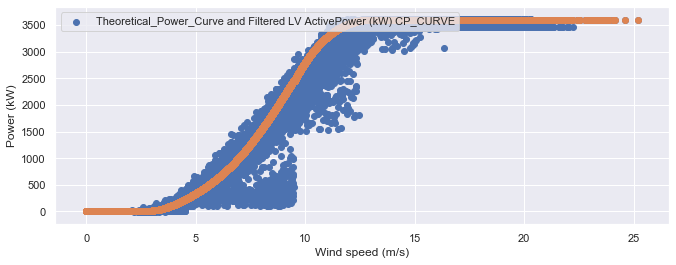

In [68]:
#Theoretical_Power_Curve and Filtered LV ActivePower (kW) CP_CURVE Visualisation
plt.scatter(new_2['Wind Speed (m/s)'],new_2['LV ActivePower (kW)'])
plt.scatter(df['Wind Speed (m/s)'],df['Theoretical_Power_Curve (KWh)'], label='Theoretical_Power_Curve (KWh)')
plt.ylabel('Power (kW)')
plt.xlabel('Wind speed (m/s)')
plt.grid(True)
plt.legend(['Theoretical_Power_Curve and Filtered LV ActivePower (kW) CP_CURVE'], loc='upper left')
plt.show()

The filtered power curve can still be improved. You can suggest best filter condition. 

Feature Engineering

Generating more features from the limited data given.

In [69]:
#Function to create more feature as Age Category
def CP_group(val):
    if val<3.5:
        return 'Region_1'
    elif val> 3.5 and val < 10:
        return 'Region_1.5'
    elif val>10 and val < 15:
        return 'Region_2'
    elif val>15 and val < 23:
        return 'Region_2.5'
    else:
        return 'Region_3'
df['Operational Category']=df['Wind Speed (m/s)'].apply(CP_group)

In [70]:
df.head(5)

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Bin,Operational Category
Date/Time,,,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904,[5.0-5.5],Region_1.5
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113,[5.5-6.0],Region_1.5
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789,[5.0-5.5],Region_1.5
01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087,[5.5-6.0],Region_1.5
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286,[5.5-6.0],Region_1.5


The feature generated is Operational category and windspeed bin which can be converted  into dummy variable for further ML prediction.
For operational category, regions are derived from the operational state of wind turbine according to the data provided. 
Region_1 : Non-operational
Region_1.5 :Max Rotor Efficinecy
Region_2 : Rated 
Region_2.5 : Reduced Rotor Efficiency
Region_3 : Cut-out

Converting the categorical data into variable

In [71]:
#Checking the data type for better understanding
df.dtypes

LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
Bin                               object
Operational Category              object
dtype: object

In [72]:
#Splitting the data into categorical data, float and Varaible
df_float = df[df.dtypes[df.dtypes == "float"].index]

df_Cat = df[df.dtypes[df.dtypes == "object"].index]

In [73]:
df_float.head(5)

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [74]:
df_Cat.head(5)

,Bin,Operational Category
Date/Time,,
01 01 2018 00:00,[5.0-5.5],Region_1.5
01 01 2018 00:10,[5.5-6.0],Region_1.5
01 01 2018 00:20,[5.0-5.5],Region_1.5
01 01 2018 00:30,[5.5-6.0],Region_1.5
01 01 2018 00:40,[5.5-6.0],Region_1.5


In [75]:
#Converting the categorical data into dummy variable for easy analysis
df_Cat = pd.get_dummies(df_Cat)

In [76]:
df_Cat.head(5)

,Bin_[0.0-0.5],Bin_[0.5-1.0],Bin_[1.0-1.5],Bin_[1.5-2.0],Bin_[10.0-10.5],Bin_[10.5-11.0],Bin_[11.0-11.5],Bin_[11.5-12.0],Bin_[12.0-12.5],Bin_[12.5-13.0],...,Bin_[7.5-8.0],Bin_[8.0-8.5],Bin_[8.5-9.0],Bin_[9.0-9.5],Bin_[9.5-10.0],Operational Category_Region_1,Operational Category_Region_1.5,Operational Category_Region_2,Operational Category_Region_2.5,Operational Category_Region_3
Date/Time,,,,,,,,,,,,,,,,,,,,,
01 01 2018 00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
01 01 2018 00:10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
01 01 2018 00:20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
01 01 2018 00:30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
01 01 2018 00:40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [77]:
#concatinating the two data type together
Result=df_float.join([df_Cat])

In [79]:
Result.head(5)

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Bin_[0.0-0.5],Bin_[0.5-1.0],Bin_[1.0-1.5],Bin_[1.5-2.0],Bin_[10.0-10.5],Bin_[10.5-11.0],...,Bin_[7.5-8.0],Bin_[8.0-8.5],Bin_[8.5-9.0],Bin_[9.0-9.5],Bin_[9.5-10.0],Operational Category_Region_1,Operational Category_Region_1.5,Operational Category_Region_2,Operational Category_Region_2.5,Operational Category_Region_3
Date/Time,,,,,,,,,,,,,,,,,,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
